In [1]:
from astropy.io.votable import is_votable, parse
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np

In [2]:
def is_VOtable(fullname):
    tag = is_votable(fullname)
    print("The file", fullname, "is a VOtable, right ?", tag)
    return tag

In [3]:
pathdata = "outputs/"
data     = ["matching_clusterGals_with_Cassata_acc_1_arcsec.vot", 
            "matching_clusterGals_with_Tasca_acc_1_arcsec.vot",
            "matching_clusterGals_with_Cassata_and_Tasca_acc_1_arcsec.vot"]

#Checking that file format is correct
for name in data:
    voTag = is_VOtable(pathdata+name)
    if voTag:        
        fullFileName = pathdata + name
        #Retrieving the data
        table = parse(fullFileName)
        full  = table.get_first_table()
        
        print("Size of", name, "is", full.array.shape[0], "\n")
    else:
        exit("Exiting")
        

The file outputs/matching_clusterGals_with_Cassata_acc_1_arcsec.vot is a VOtable, right ? True


Size of matching_clusterGals_with_Cassata_acc_1_arcsec.vot is 356 

The file outputs/matching_clusterGals_with_Tasca_acc_1_arcsec.vot is a VOtable, right ? True


Size of matching_clusterGals_with_Tasca_acc_1_arcsec.vot is 361 

The file outputs/matching_clusterGals_with_Cassata_and_Tasca_acc_1_arcsec.vot is a VOtable, right ? True


Size of matching_clusterGals_with_Cassata_and_Tasca_acc_1_arcsec.vot is 349 



In [4]:
#Getting data
cassataMatch = parse(pathdata+data[0]).get_first_table().array
tascaMatch   = parse(pathdata+data[1]).get_first_table().array
bothMatch    = parse(pathdata+data[2]).get_first_table().array

In [5]:
#Checking that the matching procedure did not duplicate galaxies
master = [bothMatch ,cassataMatch, tascaMatch]

for catalog, nameCat in zip(master, data):
    for ra, nb in zip(catalog['RA'], range(catalog['RA'].shape[0])):
        pos = np.where(catalog['RA']==ra)
        i = 1
        cnt = True
        if pos[0].shape[0] > i:
            print("RA = ", ra, "deg is present more than once at positions", nb, "and", pos[i][0], "in catalog", nameCat)
            cnt = False
    if cnt:
        print("All the galaxies are only listed once in the catalog", nameCat + ".")

All the galaxies are only listed once in the catalog matching_clusterGals_with_Cassata_acc_1_arcsec.vot.
All the galaxies are only listed once in the catalog matching_clusterGals_with_Tasca_acc_1_arcsec.vot.
All the galaxies are only listed once in the catalog matching_clusterGals_with_Cassata_and_Tasca_acc_1_arcsec.vot.


In [6]:
#Now working on the full match (bothMatch variable)
#Converting to an astropy table for simplicity
table = Table(bothMatch)
        
table

ID_Laigle_16,RA,DEC,Z_MUSE,CONFID,Blend,Defect,Revisit,ALPHA_J2000,DELTA_J2000,NUMBER,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,FLAG_HJMCC,FLUX_RADIUS,KRON_RADIUS,EBV,FLAG_PETER,FLAG_COSMOS,FLAG_DEEP,FLAG_SHALLOW,Ks_FLUX_APER2,Ks_FLUXERR_APER2,Ks_FLUX_APER3,Ks_FLUXERR_APER3,Ks_MAG_APER2,Ks_MAGERR_APER2,Ks_MAG_APER3,Ks_MAGERR_APER3,Ks_MAG_AUTO,Ks_MAGERR_AUTO,Ks_MAG_ISO,Ks_MAGERR_ISO,Ks_FLAGS,Ks_IMAFLAGS_ISO,Y_FLUX_APER2,Y_FLUXERR_APER2,Y_FLUX_APER3,Y_FLUXERR_APER3,Y_MAG_APER2,Y_MAGERR_APER2,Y_MAG_APER3,Y_MAGERR_APER3,Y_MAG_AUTO,Y_MAGERR_AUTO,Y_MAG_ISO,Y_MAGERR_ISO,Y_FLAGS,Y_IMAFLAGS_ISO,H_FLUX_APER2,H_FLUXERR_APER2,H_FLUX_APER3,H_FLUXERR_APER3,H_MAG_APER2,H_MAGERR_APER2,H_MAG_APER3,H_MAGERR_APER3,H_MAG_AUTO,H_MAGERR_AUTO,H_MAG_ISO,H_MAGERR_ISO,H_FLAGS,H_IMAFLAGS_ISO,J_FLUX_APER2,J_FLUXERR_APER2,J_FLUX_APER3,J_FLUXERR_APER3,J_MAG_APER2,J_MAGERR_APER2,J_MAG_APER3,J_MAGERR_APER3,J_MAG_AUTO,J_MAGERR_AUTO,J_MAG_ISO,J_MAGERR_ISO,J_FLAGS,J_IMAFLAGS_ISO,B_FLUX_APER2,B_FLUXERR_APER2,B_FLUX_APER3,B_FLUXERR_APER3,B_MAG_APER2,B_MAGERR_APER2,B_MAG_APER3,B_MAGERR_APER3,B_MAG_AUTO,B_MAGERR_AUTO,B_MAG_ISO,B_MAGERR_ISO,B_FLAGS,B_IMAFLAGS_ISO,V_FLUX_APER2,V_FLUXERR_APER2,V_FLUX_APER3,V_FLUXERR_APER3,V_MAG_APER2,V_MAGERR_APER2,V_MAG_APER3,V_MAGERR_APER3,V_MAG_AUTO,V_MAGERR_AUTO,V_MAG_ISO,V_MAGERR_ISO,V_FLAGS,V_IMAFLAGS_ISO,ip_FLUX_APER2,ip_FLUXERR_APER2,ip_FLUX_APER3,ip_FLUXERR_APER3,ip_MAG_APER2,ip_MAGERR_APER2,ip_MAG_APER3,ip_MAGERR_APER3,ip_MAG_AUTO,ip_MAGERR_AUTO,ip_MAG_ISO,ip_MAGERR_ISO,ip_FLAGS,ip_IMAFLAGS_ISO,r_FLUX_APER2,r_FLUXERR_APER2,r_FLUX_APER3,r_FLUXERR_APER3,r_MAG_APER2,r_MAGERR_APER2,r_MAG_APER3,r_MAGERR_APER3,r_MAG_AUTO,r_MAGERR_AUTO,r_MAG_ISO,r_MAGERR_ISO,r_FLAGS,r_IMAFLAGS_ISO,u_FLUX_APER2,u_FLUXERR_APER2,u_FLUX_APER3,u_FLUXERR_APER3,u_MAG_APER2,u_MAGERR_APER2,u_MAG_APER3,u_MAGERR_APER3,u_MAG_AUTO,u_MAGERR_AUTO,u_MAG_ISO,u_MAGERR_ISO,u_FLAGS,u_IMAFLAGS_ISO,zp_FLUX_APER2,zp_FLUXERR_APER2,zp_FLUX_APER3,zp_FLUXERR_APER3,zp_MAG_APER2,zp_MAGERR_APER2,zp_MAG_APER3,zp_MAGERR_APER3,zp_MAG_AUTO,zp_MAGERR_AUTO,zp_MAG_ISO,zp_MAGERR_ISO,zp_FLAGS,zp_IMAFLAGS_ISO,zpp_FLUX_APER2,zpp_FLUXERR_APER2,zpp_FLUX_APER3,zpp_FLUXERR_APER3,zpp_MAG_APER2,zpp_MAGERR_APER2,zpp_MAG_APER3,zpp_MAGERR_APER3,zpp_MAG_AUTO,zpp_MAGERR_AUTO,zpp_MAG_ISO,zpp_MAGERR_ISO,zpp_FLAGS,zpp_IMAFLAGS_ISO,IA484_FLUX_APER2,IA484_FLUXERR_APER2,IA484_FLUX_APER3,IA484_FLUXERR_APER3,IA484_MAG_APER2,IA484_MAGERR_APER2,IA484_MAG_APER3,IA484_MAGERR_APER3,IA484_MAG_AUTO,IA484_MAGERR_AUTO,IA484_MAG_ISO,IA484_MAGERR_ISO,IA484_FLAGS,IA484_IMAFLAGS_ISO,IA527_FLUX_APER2,IA527_FLUXERR_APER2,IA527_FLUX_APER3,IA527_FLUXERR_APER3,IA527_MAG_APER2,IA527_MAGERR_APER2,IA527_MAG_APER3,IA527_MAGERR_APER3,IA527_MAG_AUTO,IA527_MAGERR_AUTO,IA527_MAG_ISO,IA527_MAGERR_ISO,IA527_FLAGS,IA527_IMAFLAGS_ISO,IA624_FLUX_APER2,IA624_FLUXERR_APER2,IA624_FLUX_APER3,IA624_FLUXERR_APER3,IA624_MAG_APER2,IA624_MAGERR_APER2,IA624_MAG_APER3,IA624_MAGERR_APER3,IA624_MAG_AUTO,IA624_MAGERR_AUTO,IA624_MAG_ISO,IA624_MAGERR_ISO,IA624_FLAGS,IA624_IMAFLAGS_ISO,IA679_FLUX_APER2,IA679_FLUXERR_APER2,IA679_FLUX_APER3,IA679_FLUXERR_APER3,IA679_MAG_APER2,IA679_MAGERR_APER2,IA679_MAG_APER3,IA679_MAGERR_APER3,IA679_MAG_AUTO,IA679_MAGERR_AUTO,IA679_MAG_ISO,IA679_MAGERR_ISO,IA679_FLAGS,IA679_IMAFLAGS_ISO,IA738_FLUX_APER2,IA738_FLUXERR_APER2,IA738_FLUX_APER3,IA738_FLUXERR_APER3,IA738_MAG_APER2,IA738_MAGERR_APER2,IA738_MAG_APER3,IA738_MAGERR_APER3,IA738_MAG_AUTO,IA738_MAGERR_AUTO,IA738_MAG_ISO,IA738_MAGERR_ISO,IA738_FLAGS,IA738_IMAFLAGS_ISO,IA767_FLUX_APER2,IA767_FLUXERR_APER2,IA767_FLUX_APER3,IA767_FLUXERR_APER3,IA767_MAG_APER2,IA767_MAGERR_APER2,IA767_MAG_APER3,IA767_MAGERR_APER3,IA767_MAG_AUTO,IA767_MAGERR_AUTO,IA767_MAG_ISO,IA767_MAGERR_ISO,IA767_FLAGS,IA767_IMAFLAGS_ISO,IB427_FLUX_APER2,IB427_FLUXERR_APER2,IB427_FLUX_APER3,IB427_FLUXERR_APER3,IB427_MAG_APER2,IB427_MAGERR_APER2,IB427_MAG_APER3,IB427_MAGERR_APER3,IB427_MAG_AUTO,IB427_MAGERR_AUTO,IB427_MAG_ISO,IB427_MAGERR_ISO,IB427_FLAGS,IB427_IMAFLAGS_ISO,IB464_FLUX_APER2,IB46

In [7]:
#Checking that the maximum angular separation is less than 1 arcsec
print("Maximum separation is", str((table['Separation_CASSATA']*u.arcsec).max()) + ".")

Maximum separation is 0.9965565871943658 arcsec.


In [92]:
#Keep correct values by applying a mask
GF_R           = table['R_d_GF']
mask           = np.where(np.abs(GF_R)!=999)
GF_R           = GF_R[mask]
R_half_CASSATA = table['R_HALF_CASSATA'][mask]
R_half_TASCA   = table['R_HALF_TASCA'][mask]

print("There are values equal to +- 999 left in the array, right ?", np.any(np.abs(GF_R)==999))

There are values equal to +- 999 left in the array, right ? False


In [96]:
print(np.sort(GF_R))

R_d_GF
------
  0.51
  0.51
  0.51
  0.51
  0.94
  0.98
   1.7
  2.44
  2.52
  2.53
   ...
 49.57
 49.99
  50.0
  50.0
  50.0
  50.0
  50.0
  50.0
  50.0
  50.0
  50.0
Length = 262 rows


In [36]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats.mstats import chisquare

In [31]:
def linear_fit(x, A, offset):
    return A*x+offset

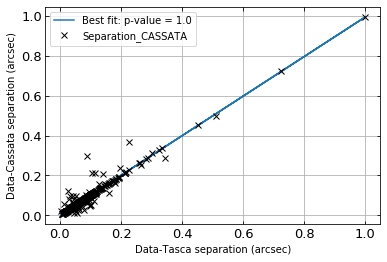

In [86]:
#Plotting the separation between data-TASCA and data-CASSATA
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', direction='in', labelsize=13)
plt.grid()

sep_TASCA   = table['Separation_TASCA']
sep_CASSATA = table['Separation_CASSATA']

#Compute linear fit
(A, offset), pcov  = curve_fit(linear_fit, sep_TASCA, sep_CASSATA, p0=[1.0, 0.0], check_finite=True)
sep_lin_fit        = linear_fit(sep_TASCA, A, offset)

#Perform chi-square test
chisq, pval = chisquare(sep_CASSATA, sep_lin_fit, ddof=2)

#Plot best-fit
plt.plot(sep_TASCA, sep_lin_fit, label="Best fit: p-value = " + str(pval))

#Plot data
plt.plot(sep_TASCA, sep_CASSATA, "kx")

plt.xlabel("Data-Tasca separation (arcsec)")
plt.ylabel("Data-Cassata separation (arcsec)")
plt.legend(loc='best')

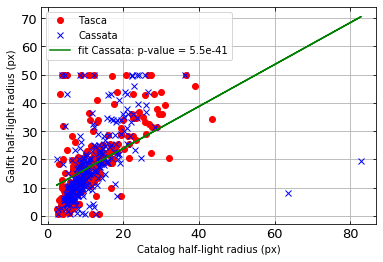

In [88]:
#Plotting the catalog radii against GF radius
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', direction='in', labelsize=13)
plt.grid()

#Compute linear fit
(A, offset), pcov  = curve_fit(linear_fit, R_half_CASSATA, GF_R, p0=[0.5, 1], check_finite=True)
sep_lin_fit        = linear_fit(R_half_CASSATA, A, offset)

#Perform chi-square test
chisq, pval = chisquare(R_half_CASSATA, sep_lin_fit, ddof=2)

#Plot data
plt.plot(R_half_TASCA, GF_R, "ro", label="Tasca")
plt.plot(R_half_CASSATA, GF_R, "bx", label="Cassata")

#Plot best fit
string = "fit Cassata: p-value = %.1e" %pval
plt.plot(R_half_CASSATA, sep_lin_fit, "g", label=string)

plt.ylabel("Galfit half-light radius (px)")
plt.xlabel("Catalog half-light radius (px)")
plt.legend(loc='best')

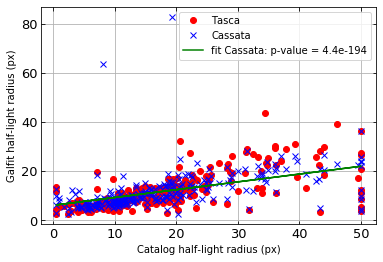

In [91]:
#Plotting the catalog radii against GF radius
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', direction='in', labelsize=13)
plt.grid()

#Compute linear fit
(A, offset), pcov  = curve_fit(linear_fit, GF_R, R_half_CASSATA, p0=[0.5, 1], check_finite=True)
sep_lin_fit        = linear_fit(GF_R, A, offset)

#Perform chi-square test
chisq, pval = chisquare(GF_R, sep_lin_fit, ddof=2)

#Plot data
plt.plot(GF_R, R_half_TASCA, "ro", label="Tasca")
plt.plot(GF_R, R_half_CASSATA, "bx", label="Cassata")

#Plot best fit
string = "fit Cassata: p-value = %.1e" %pval
plt.plot(GF_R, sep_lin_fit, "g", label=string)

plt.ylabel("Galfit half-light radius (px)")
plt.xlabel("Catalog half-light radius (px)")
plt.legend(loc='best')

1.4717745176885448 1.2618392607432005


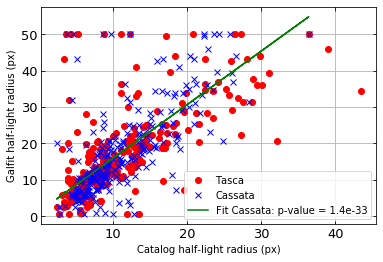

In [89]:
#If we remove the two upper points
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', direction='in', labelsize=13)
plt.grid()

m           = R_half_CASSATA<50
tmp_CASSATA = R_half_CASSATA[m]
tmp_GF      = GF_R[m]

#Compute linear fit
(A, offset), pcov  = curve_fit(linear_fit, tmp_CASSATA, tmp_GF, p0=[0.5, 1], check_finite=True)
sep_lin_fit        = linear_fit(tmp_CASSATA, A, offset)

#Perform chi-square test
chisq, pval = chisquare(tmp_CASSATA, sep_lin_fit, ddof=2)

#Plot data
plt.plot(R_half_TASCA, GF_R, "ro", label="Tasca")
plt.plot(tmp_CASSATA, tmp_GF, "bx", label="Cassata")

#Plot best fit
string = "Fit Cassata: p-value = %.1e" %pval
plt.plot(tmp_CASSATA, sep_lin_fit, "g", label=string)

plt.ylabel("Galfit half-light radius (px)")
plt.xlabel("Catalog half-light radius (px)")
plt.legend(loc='best')

print(A, offset)